https://tinyurl.com/zxyxa9ww Copy the notebook to your GDrive to edit.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip3 install transformers

In [ ]:
import torch
import random
import numpy as np

from transformers import AutoTokenizer, BertForMaskedLM

In [ ]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
device

device(type='cpu')

# Error Analysis and Explainability

Error analysis involves **examining the errors made by a system and developing a classification of them**. (This is typically best done over dev data, to avoid compromising held-out test sets.) At a superficial level, this can involve breaking things down by input length, token frequency or looking at confusion matrices. But we should not limit ourselves to examining only labels (rather than input linguistic forms) as with confusion matrices, or superficial properties of the linguistic signal. Languages are, after all, complex systems and linguistic forms are structured. So a deeper error analysis involves examining those linguistic forms and looking for patterns. 

A good error analysis tells us something about **why method X is effective or ineffective for problem Y**. This in turn provides a much richer starting point for further research, allowing us to go beyond throwing learning algorithms at the wall of tasks and seeing which stick, while allowing us to also discover which are the harder parts of a problem. 

Error analysis: Does the project provide a thoughtful error analysis, which looks for **linguistic patterns** in the **types of errors** made by the system(s) evaluated and sheds light on either **avenues for future work or the source of the strengths/weaknesses** of the systems?

Source : http://coling2018.org/error-analysis-in-research-and-writing/

Error analysis — the attempt to *analyze when, how, and why machine-learning models fail* — is a crucial part of the development cycle: **Researchers use it to suggest directions for future improvement, and practitioners make deployment decisions based on it. Since error analysis profoundly determines the direction of subsequent actions, we cannot afford it to be biased or incomplete.**



![title](https://miro.medium.com/max/1400/1*r4RwXFD0vnNl5VNLin_4Zw.png)

Source https://medium.com/@uwdata/errudite-55d5fbf3232e

Error Analysis can include **everything that helps you understand how the model behaves**, what are it's strengths and weaknesses. 

When having **access to the model's decisions**, e.g. weights for each n-gram, and they are easily understandable, we say that the model is **interpretable by design** ([Chapter 4, Interpretable Models](https://christophm.github.io/interpretable-ml-book/simple.html)) For such models, we can explore what the model chose as important features and use that in our analysis.

## Motivation (Examples)

**Language Modeling:** Predict the likelihood of a sentence P(x)

P(x) is <span style="color:green">**high**</span>: &emsp; Barack Obama served as the 44th President of the UnitedStates.

P(x) is <span style="color:red">**low**</span>: &emsp; 44th the of the President United States served Barack Obama as. *(syntax)*

P(x) is <span style="color:red">**low**</span>: &emsp; Barack Obama barked as the 44th President of the kennel. *(semantics)*

P(x) is <span style="color:red">**low**</span>: &emsp; Barack Obama served as the 44th President of the UnitedStates. *(facts)*

P(x) is <span style="color:red">**low**</span>: &emsp; Barack Obama reached a height of 50 feet tall. *(common sense)*
    
Source https://www.youtube.com/watch?v=Oh2StnRQ3qE&ab_channel=3Blue1Brown

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = BertForMaskedLM.from_pretrained("bert-base-cased")

def get_probs(sentence, word_idx):
    input_ids = tokenizer.encode(sentence)
    input_ids = torch.tensor([input_ids])
    logits = bert(input_ids)[0][0]
    sorted_probs = logits[word_idx].sort(descending=True)

    return sorted_probs

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sentence = f"Copenhagen is the capital of {tokenizer.mask_token}."
sorted_probs = get_probs(sentence, 6)
for i in range(10):
    token = tokenizer._convert_id_to_token(sorted_probs.indices[i].numpy().tolist())
    conf = sorted_probs.values[i].detach().numpy().tolist()
    print(f"{token}: {conf}")

Denmark: 18.916259765625
Sweden: 12.33653736114502
Europe: 11.822346687316895
Copenhagen: 11.669342994689941
Danish: 11.636176109313965
Scandinavia: 11.140523910522461
Latvia: 11.12883186340332
Norway: 10.961599349975586
Zealand: 10.413448333740234
Greenland: 10.1879243850708


However, since language models were never trained to solve the exact tasks that we're asking them to solve, they are:
* Very **sensitive to the wording** that we use to prompt them
* Will return an answer **even when they have no idea**

In [ ]:
sentence = f"The nurse finished {tokenizer.mask_token} work."
sorted_probs = get_probs(sentence, 4)
for i in range(10):
    token = tokenizer._convert_id_to_token(sorted_probs.indices[i].numpy().tolist())
    conf = sorted_probs.values[i].detach().numpy().tolist()
    print(f"{token}: {conf}")

her: 16.3854923248291
the: 12.918558120727539
his: 11.12331771850586
its: 10.893868446350098
their: 10.132686614990234
some: 9.50537395477295
all: 9.481547355651855
to: 9.095523834228516
up: 8.563329696655273
my: 8.469127655029297


Further reading on bias: 

https://aclanthology.org/N18-2003.pdf

https://arxiv.org/pdf/2004.09456.pdf

## Error Analysis for sentiment classification

**Starting point for an error analysis:** If my model hits 90% accuracy, why are the remaining 10% misclassified? Are there any patterns?

In [ ]:
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

### Upload the dataset 
We'll use two basic logistic regression classifiers for sentiment analysis from lab 2 with TF-IDF features and BPE. We use the dataset for fact-checking -- [Liar dataset](https://www.cs.ucsb.edu/~william/data/liar_dataset.zip).  

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.tsv to train (1).tsv
Saving valid.tsv to valid (1).tsv
Saving test.tsv to test (1).tsv
User uploaded file "train.tsv" with length 2408165 bytes
User uploaded file "valid.tsv" with length 301556 bytes
User uploaded file "test.tsv" with length 301118 bytes


# Read in the data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_data = pd.read_csv('./train.tsv', sep='\t', header=None).fillna('')
valid_data = pd.read_csv('./valid.tsv', sep='\t', header=None).fillna('')
test_data = pd.read_csv('./test.tsv', sep='\t', header=None).fillna('')
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15,9,20,19,2,an interview on CNN


## Model 1: TF-IDF classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
n = 100

vectorizer = TfidfVectorizer(max_features=1000)
features = vectorizer.fit_transform(train_data.values[:, 2])
# the raw/textual n-grams the vectorizer is using
feature_array = np.array(vectorizer.get_feature_names())
# TF-IDF scores of the words in each instance of the input datasets
tfidf_sorting = np.argsort(features.toarray()).flatten()[::-1]

# With a TF-IDF Vecotrizer, we can already tell the words that have high TF-IDF scores
# Even before feeding them to the model:
# Look-up of the top-n words at the indices with 1) highest and 2) lowest scores 
print(feature_array[tfidf_sorting][:n])
print(feature_array[tfidf_sorting][-n:])

['veterans' 'you' 'really' 'community' 'know' 'department' 'your' 'like'
 'them' 'there' 'out' 'to' 'of' 'our' 'are' 'has' 'the' 'equal'
 'employees' 'entire' 'enough' 'energy' 'estimated' 'end' 'even' 'for'
 'employee' 'else' 'every' 'elections' 'election' 'elected' 'either'
 'eight' 'effect' 'education' 'economy' 'economic' 'earth' 'earned' 'earn'
 'ever' 'fact' 'executive' 'feingold' 'food' 'florida' 'five' 'fiscal'
 'first' 'fire' 'find' 'financial' 'fight' 'fewer' 'few' 'force'
 'existing' 'fees' 'federal' 'fbi' 'favor' 'fastest' 'far' 'family'
 'earmarks' 'failed' 'experience' 'expansion' 'families' 'due' 'early'
 'currently' 'decades' 'decade' 'debt' 'debate' 'death' 'deal' 'days'
 'day' 'david' 'data' 'cutting' 'cuts' 'cut' 'current' 'each' 'cruz'
 'crist' 'crisis' 'criminal' 'crimes' 'crime' 'credit' 'creation'
 'creating' 'created' 'create' 'coverage']
['private' 'prison' 'primary' 'prices' 'previous' 'presidents' 'rape'
 'rates' 'president' 'rating' 'residents' 'research' 'r

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
features = vectorizer.fit_transform(train_data.values[:, 2])
# training a linear model, which is interpretable by design
lr = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial')
lr.fit(features, train_data.values[:, 1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
features_test = vectorizer.fit_transform(test_data.values[:, 2])
preds_tfidf = lr.predict(features_test)

In [ ]:
features_valid = vectorizer.transform(valid_data.values[:, 2])
preds_valid_tfidf = lr.predict(features_valid)

## Model 2: BPE

In [ ]:
from tqdm import tqdm
import nltk

In [ ]:
!pip install bpemb

In [ ]:
from bpemb import BPEmb

# Load english model with 25k word-pieces
bpemb_en = BPEmb(lang='en', dim=100, vs=25000)

In [ ]:
def get_bpemb_features(dataset, bpemb):
  # With bpemb we can tokenize and embed an entire document using .embed(x)
  X = [bpemb.embed(x).mean(0) for x in tqdm(dataset[:,2])]
  y = dataset[:,1]
 
  return X,y

In [ ]:
X_train,y_train = get_bpemb_features(train_data.values, bpemb_en)
X_valid,y_valid = get_bpemb_features(valid_data.values, bpemb_en)
X_test,y_test = get_bpemb_features(test_data.values, bpemb_en)
lr_bpemb = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial')
lr_bpemb.fit(X_train, y_train)

100%|██████████| 1267/1267 [00:00<00:00, 7757.24it/s]


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds_bpemb = lr_bpemb.predict(X_test)
preds_valid_bpemb = lr_bpemb.predict(X_valid)

## Classification Performance Comparison

Looking at the **classification report and the confusion matrix** is the most basic step of performing error analysis - you can find which classes are confused with which other classes most often and compare the performance of the different classes. Differences in the performance allow for a founded model choice.

In [ ]:
# TF-IDF model 
report = classification_report(y_test, preds_tfidf, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
barely-true,0.166667,0.099057,0.124260,212.000000
false,0.230986,0.329317,0.271523,249.000000
half-true,0.221198,0.181132,0.199170,265.000000
mostly-true,0.215152,0.294606,0.248687,241.000000
pants-fire,0.090909,0.021739,0.035088,92.000000
true,0.184332,0.192308,0.188235,208.000000
accuracy,0.208366,0.208366,0.208366,0.208366
macro avg,0.184874,0.186360,0.177827,1267.000000
weighted avg,0.197334,0.208366,0.196564,1267.000000


In [ ]:
# BPEmb model 
report = classification_report(y_test, preds_bpemb, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
barely-true,0.174312,0.089623,0.118380,212.000000
false,0.241758,0.353414,0.287113,249.000000
half-true,0.234604,0.301887,0.264026,265.000000
mostly-true,0.251656,0.315353,0.279926,241.000000
pants-fire,0.451613,0.152174,0.227642,92.000000
true,0.233333,0.134615,0.170732,208.000000
accuracy,0.240726,0.240726,0.240726,0.240726
macro avg,0.264546,0.224511,0.224637,1267.000000
weighted avg,0.244714,0.240726,0.229260,1267.000000


### Confusion Matrix Comparison

In [ ]:
confusion_matrix(valid_data.values[:, 1], preds_valid_tfidf)

array([[19, 67, 42, 67,  2, 40],
       [32, 73, 53, 64,  4, 37],
       [19, 67, 50, 66,  0, 46],
       [25, 52, 54, 67,  7, 46],
       [ 8, 36, 25, 20,  2, 25],
       [17, 32, 43, 52,  2, 23]])

In [ ]:
valid_values = valid_data.values[:, 1]
confusion_matrix(valid_values, preds_valid_bpemb)

array([[20, 83, 74, 40,  5, 15],
       [28, 98, 67, 37, 12, 21],
       [17, 63, 86, 60,  4, 18],
       [16, 70, 53, 76,  2, 34],
       [13, 48, 23,  9, 14,  9],
       [10, 37, 39, 53,  1, 29]])

Can you spot any insights?

## Model's Feature Weights

We can now see what are the most importand words for each class by looking at the weights the model assigned to each feature in the input.

barely-true


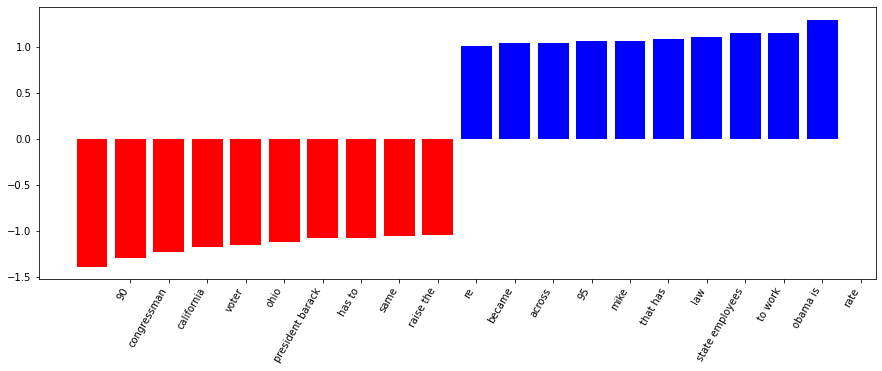

false


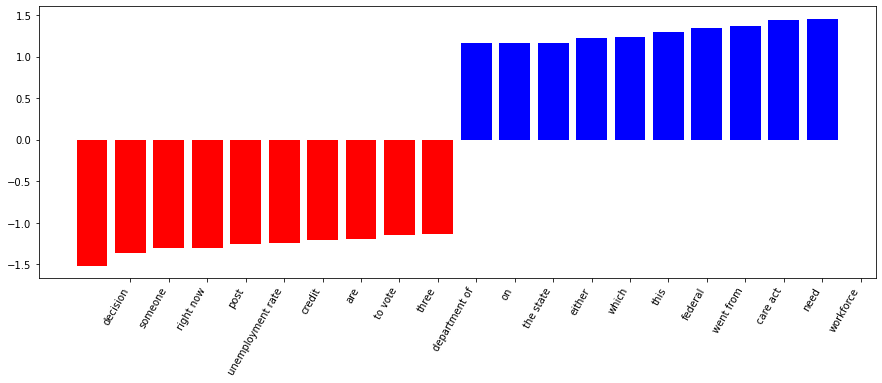

half-true


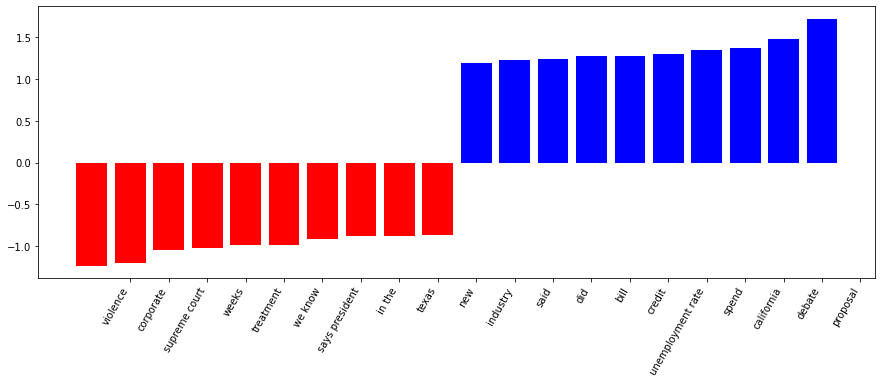

mostly-true


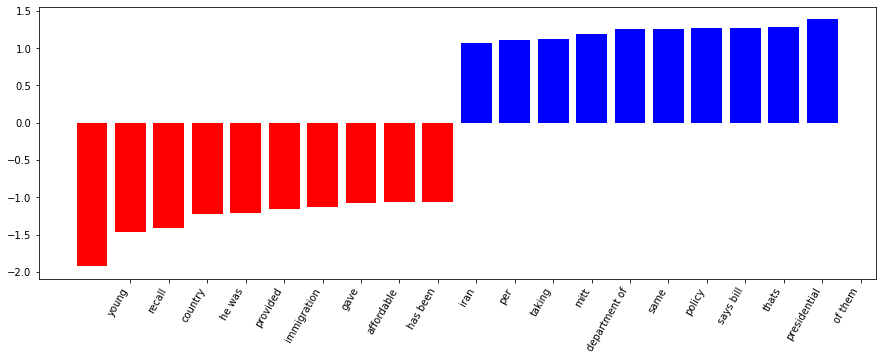

pants-fire


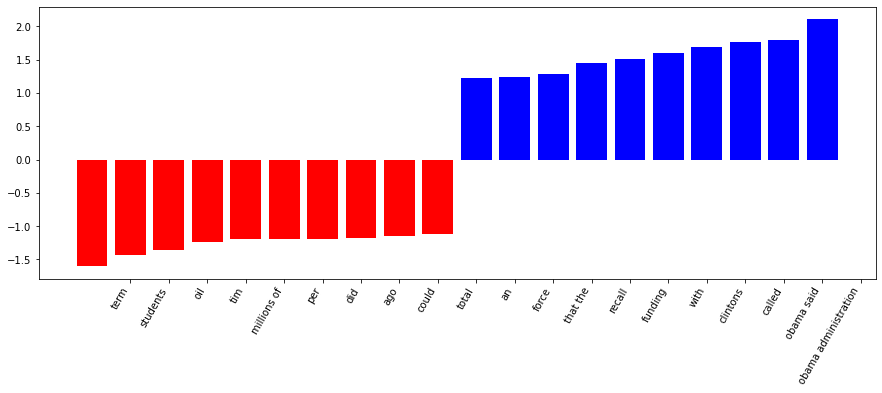

true


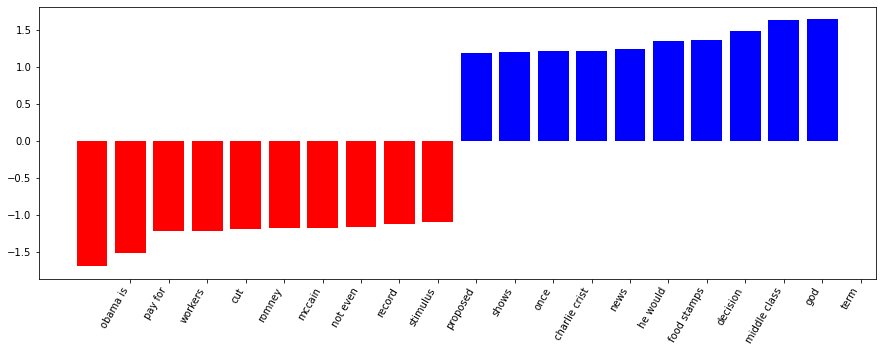

In [ ]:
top_features = 10
# get the model's weights: n_classes x n_features - (? , ?)
all_class_coef = lr.coef_

for i, cls in enumerate(lr.classes_): # for each of the classes
  print(cls)
  # get the weights for the class
  coef = all_class_coef[i]
  # find the top negative and positive features for the class
  top_positive_coefficients = np.argsort(coef)[-top_features:]
  top_negative_coefficients = np.argsort(coef)[:top_features]
  # combine them in one array
  top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
  # create plot - humans tend to understand better plot visualizations
  feature_names = vectorizer.get_feature_names()
  plt.figure(figsize=(15, 5))
  colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
  plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
  feature_names = np.array(feature_names)
  plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
  plt.show()

## Error classification 

We can now look at the predictions of the model to try and spot any problems or particular features of the model. 

We will look at instances the model classifies **in/correctly**, which in turn can be broken down to: **instances with high/ low/ medium confidence**. To do that, we'll use the **probability/confidence** of the model's prediction, which is available for all ML models.

In [ ]:
# get the probability of the model
valid_pred_prob = lr_bpemb.predict_proba(X_valid)

In [ ]:
from collections import defaultdict

# collect correct and wrong predictions, keeping the confidence of the prediction
errors = defaultdict(lambda: [])
correct_preds = defaultdict(lambda: [])

for (i, instance), pred, pred_score in zip(valid_data.iterrows(), preds_valid_bpemb, valid_pred_prob):
  # get the index/id of the gold class in the probability array (n_classes x 1)
  index_of_class = np.where(lr_bpemb.classes_ == instance[1])
  # get the index/id of the predicted class in the probability array (n_classes x 1)
  index_of_pred_class =  np.where(lr_bpemb.classes_ == pred)
  # depending on whether the prediction is correct, collect the instances as errors or correct predictions
  if pred != instance[1]:
    errors[instance[1]].append((instance[2], pred_score[index_of_class], pred_score[index_of_pred_class], pred))
  else:
    correct_preds[instance[1]].append((instance[2], pred_score[index_of_class], pred_score, pred))

In [ ]:
import pprint

for cls in lr_bpemb.classes_:
  print(cls)
  print('High probability for correct class')
  # sort the errors by the probability of the gold class and look at the:
  # 1. instances where the gold class had a high probability
  pprint.pprint(sorted(errors[cls], key=lambda x: x[1])[-10:])
  print('Low probability for correct class')
  # 1. instances where the gold class had a low probability
  pprint.pprint(sorted(errors[cls], key=lambda x: x[1])[:10])

barely-true
High probability for correct class
[('Just like Donald Trump, David Jolly wants to outlaw a womans right to '
  'choose.',
  array([0.22251137]),
  array([0.23379486]),
  'false'),
 ('Stimulus dollars paid for windmills from China.',
  array([0.22542609]),
  array([0.26144215]),
  'half-true'),
 ('Obamacare is costing 2 million jobs.',
  array([0.22576654]),
  array([0.24788424]),
  'half-true'),
 ('Gerry Connolly and his fellow Democrats went on a spending spree and now '
  'their credit card is maxed out.',
  array([0.22596097]),
  array([0.24121691]),
  'half-true'),
 ('Says Hillary Clinton has been saying lately that she thinks that I am, not '
  'qualifiedto be president.',
  array([0.23431039]),
  array([0.24782692]),
  'false'),
 ('Rick Scotts prison plan would cut Floridas prison budget in half, close '
  'prisons, and release tens of thousands of prisoners early -- murderers, '
  'rapists, sex offenders, armed robbers, drug dealers.',
  array([0.23454344]),
  array

In [ ]:
# We can check for some instances what were their TF-IDF scores (the input for the model)
text = 'Ken Lanci is a lifelong Clevelander'
print(vectorizer.transform([text]))
text = 'Ken Lanci is a lifelong Clevelander'
print([word for word in text.lower().split() if word in vectorizer.vocabulary_])

  (0, 414)	1.0
['is']


In [ ]:
# do the same for correct predictions
for cls in lr_bpemb.classes_:
  print(cls)
  print('High probability for correct class')
  pprint.pprint(sorted(correct_preds[cls], key=lambda x: x[1])[-10:])
  print('Low probability for correct class')
  pprint.pprint(sorted(correct_preds[cls], key=lambda x: x[1])[:10])

barely-true
High probability for correct class
[('Austin politicians want to cram more kids into classrooms so they dont have '
  'to make the tough decisions to balance the budget.',
  array([0.26302518]),
  array([0.26302518, 0.18762024, 0.24028468, 0.15297156, 0.05470604,
       0.10139231]),
  'barely-true'),
 ('Rosalyn Dance voted against President Obamas Medicaid expansion.',
  array([0.27706225]),
  array([0.27706225, 0.27214181, 0.1821155 , 0.09545814, 0.11163969,
       0.06158261]),
  'barely-true'),
 ('Says Hillary Clinton was asked repeatedly to provide security in Benghazi '
  'on several occasions, including direct cables.',
  array([0.28209335]),
  array([0.28209335, 0.2077499 , 0.16141698, 0.11435118, 0.1009411 ,
       0.13344748]),
  'barely-true'),
 ('Says Elizabeth Warren lied when she says I want to abolish the Federal '
  'Minimum Wage.',
  array([0.28353144]),
  array([0.28353144, 0.21341335, 0.18486839, 0.15152536, 0.05881866,
       0.1078428 ]),
  'barely-true

# Error Analysis with a Transformer Model

## Learning Curves
Error analysis can start as early as fine-tuning the model. Observing different **learning curves** of the loss function of both the training and the development set can tell whether we need more data; we need a bigged dev set; we need a more complex model; whether the model is learning anything/overfitting, etc. 

http://mlwiki.org/index.php/Learning_Curves

https://medium.com/uwaterloo-voice/error-analysis-in-deep-learning-6df3b3d335af


Model Debugging can be made easy with external tools, too:

https://wandb.ai/latentspace/published-work/The-Science-of-Debugging-with-W&B-Reports--Vmlldzo4OTI3Ng

"Those who don't track training are doomed to repeat it."

In [ ]:
!pip3 install transformers

In [ ]:
import torch
import random
import numpy as np
import pandas as pd

from functools import partial
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from typing import List, Tuple
from tqdm import tqdm_notebook as tqdm

In [ ]:
from transformers import PreTrainedTokenizer
from transformers import RobertaTokenizer
from transformers import RobertaConfig
from transformers import RobertaForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from typing import List, Tuple

In [ ]:
def accuracy(logits, labels):
  logits = np.asarray(logits).reshape(-1, len(logits[0]))
  labels = np.asarray(labels).reshape(-1)
  return np.sum(np.argmax(logits, axis=-1) == labels).astype(np.float32) / float(labels.shape[0])

def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []
  losses_all = []
  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      attention_mask = batch[1]
      labels = batch[2]

      loss, logits = model(input_ids, attention_mask, labels=labels, return_dict=False)
      labels_all.extend(list(labels.detach().cpu().numpy()))
      logits_all.extend(list(logits.detach().cpu().numpy()))
      losses_all.append(loss.detach().cpu().numpy())
    acc = accuracy(logits_all, labels_all)

    return acc, np.mean(losses_all)

def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
    scheduler = None
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_acc = 0.0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for i, batch in tqdm(enumerate(train_dl)):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      attention_mask = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      loss, logits = model(input_ids, attention_mask, labels=labels, return_dict=False)
      wandb.log({'loss': loss.item()})
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      if scheduler is not None:
        scheduler.step()
      # CHANGED CODE -- as the Transformer model trains for a few epoch, 
      # we might want to look at the learning curves each other step
      if i % 100 == 0:
        acc, val_loss = evaluate(model, valid_dl)
        wandb.log({'acc': acc, 'train_loss': np.mean(loss_epoch), 'val_loss': val_loss})

    # Perform inline evaluation at the end of the epoch
    acc, val_loss = evaluate(model, valid_dl)
    wandb.log({'acc': acc, 'train_loss': np.mean(loss_epoch), 'val_loss': val_loss})
    print(f'Validation accuracy: {acc}, train loss: {np.mean(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    best_model = model.state_dict()
    if acc > best_acc:
      torch.save(model.state_dict(), 'best_model')
      best_acc = acc
        #gc.collect()

  model.load_state_dict(best_model)
  return model, losses

In [ ]:
def text_to_batch_transformer(text: List, tokenizer: PreTrainedTokenizer) -> Tuple[List, List]:
    """Turn a piece of text into a batch for transformer model

    :param text: The text to tokenize and encode
    :param tokenizer: The tokenizer to use
    :return: A list of IDs and a mask
    """
    input_ids = [tokenizer.encode(t, add_special_tokens=True, truncation=True) for t in text]

    masks = [[1] * len(i) for i in input_ids]

    return input_ids, masks

class ClassificationDatasetReader(Dataset):
  def __init__(self, df, tokenizer):
    self.df = df
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.values[idx]
    # Calls the text_to_batch function
    input_ids, masks = text_to_batch_transformer([row[2]], self.tokenizer)
    label = label_map[row[1]]
    return input_ids, masks, label

In [ ]:
label_map = {l:i for i,l in enumerate((set(train_data.values[:,1]) | set(valid_data.values[:,1]) | set(test_data.values[:,1])))}
num_labels = len(label_map)

print(label_map)

{'true': 0, 'barely-true': 1, 'false': 2, 'mostly-true': 3, 'pants-fire': 4, 'half-true': 5}


In [ ]:
def collate_batch_transformer(pad_id, input_data: Tuple) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    input_ids = [i[0][0] for i in input_data]
    masks = [i[1][0] for i in input_data]
    labels = [i[2] for i in input_data]

    max_length = max([len(i) for i in input_ids])

    input_ids = [(i + [pad_id] * (max_length - len(i))) for i in input_ids]
    masks = [(m + [pad_id] * (max_length - len(m))) for m in masks]

    assert (all(len(i) == max_length for i in input_ids))
    assert (all(len(m) == max_length for m in masks))
    return torch.tensor(input_ids), torch.tensor(masks), torch.tensor(labels)

In [ ]:
# a few steps needed to initialize the project in WANDB
!pip install wandb -qqq
import wandb
wandb.login()

wandb: Currently logged in as: kstanczak (use `wandb login --relogin` to force relogin)


True

In [ ]:
wandb.init(project="lab-5-roberta",
           config={
               "batch_size": 8,
               "learning_rate": 5e-5,
               "dataset": "LIAR",
           })

In [ ]:
weight_decay = 0.01
n_epochs = 2
lr = 3e-5

# Get the device
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

# Create the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
vocabulary = tokenizer.get_vocab()

# Create the dataset readers
train_dataset = ClassificationDatasetReader(train_data, tokenizer)
# dataset loaded lazily with N workers in parallel
collate_fn = partial(collate_batch_transformer, 0)
train_dl = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=collate_fn, num_workers=8)

valid_dataset = ClassificationDatasetReader(valid_data, tokenizer)
valid_dl = DataLoader(valid_dataset, batch_size=6, collate_fn=collate_fn, num_workers=8)

config = RobertaConfig.from_pretrained('roberta-base', num_labels=6)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config).to(device)

# Create the optimizer
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    200,
    n_epochs * len(train_dl)
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fro

In [ ]:
# magic to have plots of the learning curves
%%wandb

model, losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device, scheduler)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Validation accuracy: 0.20482866043613707, train loss: 1.7665990396208


0it [00:00, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]